# German-to-English Machine Translation System

In this notebook, we will go through an example of building and training a long short-term memory (LSTM) Seq2seq model with and without attention from scratch. It is trained on the [Multi30K](https://arxiv.org/abs/1605.00459) dataset with a training/validation/testing split of 29,000/1,014/1,000 examples. We also implement both greedy and beam search algorithms for inference. For the LSTM + attention model with beam search, the trained model achieves a BLEU score of ~37-38.

## Setup

Let's install and import the necessary dependencies:
* `torch` for modeling and training
* `torchtext` for data collection
* `sentencepiece` for subword tokenization
* `sacrebleu` for BLEU score evaluation

In [1]:
!pip install --upgrade sacrebleu sentencepiece
!pip install torchtext==0.6.0

# Standard library imports
import json
import math
import random
import pdb

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import sacrebleu
import sentencepiece
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import tqdm.notebook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.7 MB/s eta 0:00:00


Now let's confirm we have GPU access:

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


## Loading the Multi30K Dataset

In [3]:
from torchtext.datasets import Multi30k

Multi30k.urls = [
    "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz",
    "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz",
    "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt16_task1_test.tar.gz"
]

extensions = [".de", ".en"]
source_field = torchtext.data.Field(tokenize=lambda x: x)
target_field = torchtext.data.Field(tokenize=lambda x: x)
training_data, validation_data, test_data = torchtext.datasets.Multi30k.splits(
    extensions, [source_field, target_field], root="/content/", test="test")

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 25.8MB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 8.50MB/s]

downloading mmt16_task1_test.tar.gz



mmt16_task1_test.tar.gz: 100%|██████████| 67.1k/67.1k [00:00<00:00, 5.84MB/s]


## Creating the Vocabulary

In this project, we use the `sentencepiece` tokenizer to create a joint German-English subword vocabulary. This is a relatively small dataset so we will use a small vocabulary size.

In [4]:
# Define the special tokens
args = {
  "pad_id": 0,
  "bos_id": 1,
  "eos_id": 2,
  "unk_id": 3,
  "input": "/content/multi30k/train.de,/content/multi30k/train.en",
  "vocab_size": 8000,
  "model_prefix": "multi30k",
}
combined_args = " ".join(
    "--{}={}".format(key, value) for key, value in args.items())
sentencepiece.SentencePieceTrainer.Train(combined_args)

# Load the vocabulary from the binary file
vocab = sentencepiece.SentencePieceProcessor()
vocab.Load("multi30k.model")

# Get the vocab size
print("Vocabulary size:", vocab.GetPieceSize())

Vocabulary size: 8000


Now we define the padding, beginning-of-sentence, and end-of-sentence tokens:

In [5]:
pad_id = vocab.PieceToId("<pad>")
bos_id = vocab.PieceToId("<s>")
eos_id = vocab.PieceToId("</s>")

## Baseline sequence-to-sequence model

We first write some batched functions to convert our input sentences into the subword indices.

In [6]:
from torch.nn.utils.rnn import pad_sequence

def make_batch(sentences):
  """
  Converts a list of sentences into a batch of subword indices.

  Args:
    sentences: A list of sentences (string types)

  Returns:
    A LongTensor of size (max_sequence_length, batch_size) containing the
    subword indices for the sentences, where max_sequence_length is the length
    of the longest sentence as encoded by the subword vocabulary and batch_size
    is the number of sentences in the batch. A beginning-of-sentence token
    is included before each sequence, and an end-of-sentence token is
    included after each sequence. Empty slots at the end of shorter sequences
    are filled with padding tokens.
  """

  # Sandwich each sentence with BOS and EOS tokens
  sequences = []
  for sentence in sentences:
    ids = [bos_id] + vocab.EncodeAsIds(sentence) + [eos_id]
    sequences.append(torch.tensor(ids, dtype=torch.long))

  # Pad the sequences to the max length using pad_sequence
  batch = pad_sequence(sequences, padding_value=pad_id)

  return batch.to(device)

def make_batch_iterator(dataset, batch_size, shuffle=False):
  """
  Make a batch iterator that yields source-target pairs.

  Args:
    dataset: A torchtext dataset object.
    batch_size: An integer batch size.
    shuffle: A boolean indicating whether to shuffle the examples.

  Returns:
    Pairs of tensors constructed by calling the make_batch function on the
    source and target sentences in the current group of examples. The max
    sequence length can differ between the source and target tensor, but the
    batch size will be the same.
  """
  # Convert to list
  examples = list(dataset)

  # Shuffle if you want
  if shuffle:
    random.shuffle(examples)

  # Loop over batches of language pairs
  for start_index in range(0, len(examples), batch_size):
    example_batch = examples[start_index:start_index + batch_size]
    source_sentences = [example.src for example in example_batch]
    target_sentences = [example.trg for example in example_batch]
    yield make_batch(source_sentences), make_batch(target_sentences)

Here we define the baseline Seq2seq model. It consists of a bidirectional LSTM encoder that encodes the input sentence into a fixed-size representation, and an LSTM decoder that uses this representation to produce the output sentence.



In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Baseline model class
class Seq2seqBaseline(nn.Module):
  def __init__(self, vocab_size=8000, embedding_dim=512, hidden_size=512,
               num_layers=2, dropout=0.3):
    super().__init__()

    # Embedding layer shared by encoder and decoder
    # Converts indices to embeddings
    # Dimension: (# batch_size) x (vocab_size) x (embedding_dim)
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_id)

    # Bidirectional LSTM encoder
    self.encoder = nn.LSTM(embedding_dim, hidden_size, num_layers=num_layers,
      dropout=dropout if num_layers > 1 else 0, bidirectional=True)

    # Decoder LSTM (unidirectional)
    self.decoder = nn.LSTM(embedding_dim, hidden_size, num_layers=num_layers,
      dropout=dropout if num_layers > 1 else 0, bidirectional=False)

    # Projection to convert encoder hidden state to decoder initial hidden state
    # size (hidden_size*2 per layer b/c encoder is bidirectional)
    self.hidden_proj_h = nn.Linear(hidden_size * 2, hidden_size)
    self.hidden_proj_c = nn.Linear(hidden_size * 2, hidden_size)

    # Output projection to vocab size
    self.output_projection = nn.Linear(hidden_size, vocab_size)

  def encode(self, source):
    """
    Args:
      source: (max_source_length, batch_size)
    Returns:
      encoder_output: (max_source_length, batch_size, hidden_size * 2)
      encoder_mask: (max_source_length, batch_size) bool tensor
      encoder_hidden: tuple of (h_n, c_n), (num_layers, batch_size, hidden_size)
    """
    # Get the max_source_length
    lengths = torch.sum(source != pad_id, dim=0)

    # Embed (max_source_length, batch_size, embedding_dim)
    embedded = self.embedding(source)

    # Pack padded sequence for variable lengths
    # Ignores the padding tokens to make it more efficient
    packed = pack_padded_sequence(embedded, lengths.cpu(), enforce_sorted=False)

    # Encode the packed sequence
    packed_output, (h_n, c_n) = self.encoder(packed)

    # Unpack outputs (max_len, batch_size, hidden_size*2)
    encoder_output, _ = pad_packed_sequence(packed_output)

    # Create mask where padding tokens are True
    encoder_mask = (source == pad_id)

    # h_n shape: (num_layers * 2, batch_size, hidden_size)
    # Split forward and backward states (num_layers, batch_size, hidden_size)
    h_forward = h_n[0::2]
    h_backward = h_n[1::2]
    c_forward = c_n[0::2]
    c_backward = c_n[1::2]

    # Concatenate (along hidden_size dim)
    # (num_layers, batch_size, hidden_size*2)
    h_cat = torch.cat([h_forward, h_backward], dim=2)
    c_cat = torch.cat([c_forward, c_backward], dim=2)

    # Project to decoder hidden size
    # (num_layers, batch_size, hidden_size)
    h_proj = self.hidden_proj_h(h_cat)
    c_proj = self.hidden_proj_c(c_cat)

    # Get hidden encoder state
    encoder_hidden = (h_proj, c_proj)

    return encoder_output, encoder_mask, encoder_hidden

  def decode(self, decoder_input, initial_hidden, encoder_output, encoder_mask):
    """
    Args:
      decoder_input: (max_decoder_len, batch_size)
      initial_hidden: tuple (h_0, c_0), each (num_layers, batch_size,
      hidden_size)
      encoder_output and encoder_mask not used here.

    Returns:
      logits: (max_decoder_len, batch_size, vocab_size)
      decoder_hidden: same shape as initial_hidden
      attention_weights: None (for baseline)
    """
    # Embed the decoder input
    embedded = self.embedding(decoder_input)

    # Decode using the initial hidden state
    output, decoder_hidden = self.decoder(embedded, initial_hidden)

    # Project output to vocab size
    logits = self.output_projection(output)

    return logits, decoder_hidden, None

  def compute_loss(self, source, target):
    """
    Compute cross-entropy loss for prediction on target sequences.

    Args:
      source: (max_source_length, batch_size)
      target: (max_target_length, batch_size)
    """
    # Encode source
    encoder_output, encoder_mask, encoder_hidden = self.encode(source)

    # Prepare decoder input and target output by removing the last and first
    # tokens from the target, respectively
    # We want the decoder_input to predict target_output as closely as possible
    decoder_input = target[:-1]
    target_output = target[1:]

    # Get the logits
    logits, _, _ = self.decode(decoder_input, encoder_hidden, encoder_output,
                               encoder_mask)
    # Flatten for loss
    logits_flat = logits.reshape(-1, logits.size(-1))
    target_flat = target_output.reshape(-1)

    # Calculate the loss using cross entropy
    loss = F.cross_entropy(logits_flat, target_flat, ignore_index=pad_id)

    return loss


For training the Seq2seq model, we use cross-entropy as our loss function. Specifically, for each time step we compare the target token and the token with the highest predicted probability. For parameter optimization, we use Adam with a learning rate of 1e-3 and a weight decay of 1e-5 (to prevent overfitting). We also evaluate the token-level accuracy to see how well the current set of parameters do on the validation set.

In [8]:
def train(model, num_epochs, batch_size, model_file):
  """
  Train the model and save its best checkpoint.

  Model performance across epochs is evaluated using token-level accuracy on the
  validation set. The best checkpoint obtained during training will be stored on
  disk and loaded back into the model at the end of training.
  """
  # Using Adam as the optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

  # Initialize the accuracy
  best_accuracy = 0.0

  # Using tqdm library to visualize progress
  for epoch in tqdm.notebook.trange(num_epochs, desc="training", unit="epoch"):

    with tqdm.notebook.tqdm(
      # Make batches of the training data
      make_batch_iterator(training_data, batch_size, shuffle=True),
      desc="epoch {}".format(epoch + 1), unit="batch",
      total=math.ceil(len(training_data) / batch_size)) as batch_iterator:

      # Enable dropout in training
      model.train()

      # Initialize loss
      total_loss = 0.0

      # Loop over batches
      for i, (source, target) in enumerate(batch_iterator, start=1):

        # Zero out the gradients for the new batch
        optimizer.zero_grad()

        # Do a forward pass and compute the loss
        loss = model.compute_loss(source, target)
        total_loss += loss.item()

        # Backpropagation
        loss.backward()

        # Update the parameters
        optimizer.step()
        batch_iterator.set_postfix(mean_loss=total_loss / i)

      # Predict the next tokens (those with the highest probability)
      validation_accuracy = token_level_accuracy(model, validation_data)

      # Show mean loss updates
      batch_iterator.set_postfix(mean_loss=total_loss / i,
        validation_token_accuracy=validation_accuracy)

      # Save model if our validation accuracy improves
      if validation_accuracy > best_accuracy:
        print("New best validation accuracy of {:.2f}, saving model "
              "checkpoint to {}".format(validation_accuracy, model_file))
        torch.save(model.state_dict(), model_file)
        best_accuracy = validation_accuracy

  print("Reloading best model checkpoint from {}".format(model_file))
  model.load_state_dict(torch.load(model_file))

def token_level_accuracy(model, dataset, batch_size=64):
  """
  Computes token-level accuracy on the validation set.

  """
  # Switch to inference
  model.eval()

  # Initialize for accuracy metrics
  total_predictions = 0
  correct_predictions = 0

  with torch.no_grad():

    # Loop over batches of language pairs
    for source, target in make_batch_iterator(dataset, batch_size):

      # Encode the source
      encoder_output, encoder_mask, encoder_hidden = model.encode(source)

      # Get the target tokens for each time step
      decoder_input, decoder_target = target[:-1], target[1:]

      # Get the probability distribution of predicted tokens
      logits, decoder_hidden, attention_weights = model.decode(
        decoder_input, encoder_hidden, encoder_output, encoder_mask)

      # Get the total number of predictions by omitting padding tokens
      total_predictions += (decoder_target != pad_id).sum().item()

      # Get number of correct predictions
      correct_predictions += ((decoder_target != pad_id) &
        (decoder_target == logits.argmax(2))).sum().item()

  # Get the total accuracy on the validation set
  accuracy = 100 * correct_predictions / total_predictions

  return accuracy

Now we go ahead and train the baseline model!

In [9]:
# Choose the number of epochs and batch size
num_epochs = 10
batch_size = 16

# Initialize model
baseline_model = Seq2seqBaseline().to(device)

# Now pass the model to the training function
train(baseline_model, num_epochs, batch_size, "baseline_model.pt")

training:   0%|          | 0/10 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/1813 [00:00<?, ?batch/s]

New best validation accuracy of 44.00, saving model checkpoint to baseline_model.pt


epoch 2:   0%|          | 0/1813 [00:00<?, ?batch/s]

New best validation accuracy of 48.74, saving model checkpoint to baseline_model.pt


epoch 3:   0%|          | 0/1813 [00:00<?, ?batch/s]

New best validation accuracy of 51.54, saving model checkpoint to baseline_model.pt


epoch 4:   0%|          | 0/1813 [00:00<?, ?batch/s]

New best validation accuracy of 54.28, saving model checkpoint to baseline_model.pt


epoch 5:   0%|          | 0/1813 [00:00<?, ?batch/s]

New best validation accuracy of 55.86, saving model checkpoint to baseline_model.pt


epoch 6:   0%|          | 0/1813 [00:00<?, ?batch/s]

New best validation accuracy of 56.53, saving model checkpoint to baseline_model.pt


epoch 7:   0%|          | 0/1813 [00:00<?, ?batch/s]

New best validation accuracy of 57.20, saving model checkpoint to baseline_model.pt


epoch 8:   0%|          | 0/1813 [00:00<?, ?batch/s]

New best validation accuracy of 58.16, saving model checkpoint to baseline_model.pt


epoch 9:   0%|          | 0/1813 [00:00<?, ?batch/s]

epoch 10:   0%|          | 0/1813 [00:00<?, ?batch/s]

New best validation accuracy of 58.41, saving model checkpoint to baseline_model.pt
Reloading best model checkpoint from baseline_model.pt


# Inference with Greedy Search

Now we implement greedy search, which is more simple compared to beam search. For every input token, it selects the most probable translation token as predicted by the decoder. This is the most efficient method of inference we explore here. However, the known downside is that each step is irreversible and thus may not be able to find the overall most probable prediction for a full sequence.

In [10]:
def predict_greedy(model, sentences, max_length=100):
  """
  Make predictions for the given inputs using greedy inference.

  Args:
    model: A sequence-to-sequence model
    sentences: A list of input sentences (string type)
    max_length: The maximum length at which to truncate outputs in order to
      avoid non-terminating inference

  Returns:
    A list of predicted translations (string type)
  """
  # Convert sentences to token indices
  batch = make_batch(sentences)

  with torch.no_grad():
    # Encode the source
    encoder_output, encoder_mask, encoder_hidden = model.encode(batch)
    batch_size = batch.size(1)

    # Decoder starts with BOS tokens for all items in batch
    seq = torch.full((1, batch_size), bos_id, dtype=torch.long, device=device)

    # Bool tensor to keep track of whether each sentence is finished
    finished = torch.zeros(batch_size, dtype=torch.bool, device=device)

    # Loop over the designated maximum length of our output string
    for _ in range(max_length):

      # Decode full sequence so far in one call
      logits, decoder_hidden, attention_weights = model.decode(
          seq, encoder_hidden, encoder_output, encoder_mask)

      # Take the logits from the previous step
      next_logits = logits[-1, :, :]

      # Force the pad token to be chosen if the sentence is completed
      if finished.any():
        next_logits[finished] += 1e9 * torch.eye((next_logits.size(1)),
                                                   device=device)[pad_id]
      # Choose the most probable token
      # Note we don't have to do softmax here since there is only 1
      # inference per input sentence
      next_tokens = next_logits.argmax(dim=-1)

      # Concatenate to the current sequence
      seq = torch.cat([seq, next_tokens.reshape(-1,batch_size)], dim=0)

      # Mark finished sequences
      finished |= (next_tokens == eos_id)

      # End early if all examples in the batch are completed
      if finished.all():
        break

    # Convert token IDs to text
    decoded_sentences = []
    for i in range(batch_size):
      ids = seq[:, i].tolist()
      decoded = vocab.DecodeIds(ids)
      decoded_sentences.append(decoded)

    return decoded_sentences

def evaluate(model, dataset, batch_size=64, method="greedy"):
  """
  Evaluate the performance of inference using BLEU score.

  """
  assert method in {"greedy", "beam"}

  # Get source and target sentences from the dataset
  source_sentences = [example.src for example in dataset]
  target_sentences = [example.trg for example in dataset]

  # Inference mode
  model.eval()
  predictions = []
  with torch.no_grad():

    # Loop over batches and predict translations
    for start_index in range(0, len(source_sentences), batch_size):

      # If using greedy search
      if method == "greedy":
        prediction_batch = predict_greedy(
            model, source_sentences[start_index:start_index + batch_size])

      # If beam search
      else:
        prediction_batch = predict_beam(
            model, source_sentences[start_index:start_index + batch_size])
        # Take the most probable prediction from beam search
        prediction_batch = [candidates[0] for candidates in prediction_batch]
      predictions.extend(prediction_batch)

  # Calculate BLEU score
  return sacrebleu.corpus_bleu(predictions, [target_sentences]).score

print("Baseline model validation BLEU using greedy search:",
      evaluate(baseline_model, validation_data))

Baseline model validation BLEU using greedy search: 22.157991511020533


Let's show some example predictions!

In [11]:
def show_predictions(model, num_examples=4, include_beam=False):
  """
  Show some example predictions for funsies.

  """
  for example in validation_data[:num_examples]:
    print("Input:")
    print(" ", example.src)
    print("Target:")
    print(" ", example.trg)
    print("Greedy prediction:")
    print(" ", predict_greedy(model, [example.src])[0])
    if include_beam:
      print("Beam predictions:")
      for candidate in predict_beam(model, [example.src])[0]:
        print(" ", candidate)
    print("-------------------------------------------------------------------")

print("Baseline model sample predictions:")
print()
show_predictions(baseline_model)

Baseline model sample predictions:

Input:
  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target:
  A group of men are loading cotton onto a truck
Greedy prediction:
  A group of men are picking up trash on a road.
-------------------------------------------------------------------
Input:
  Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target:
  A man sleeping in a green room on a couch.
Greedy prediction:
  A man is sleeping on a couch in a green room.
-------------------------------------------------------------------
Input:
  Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
Target:
  A boy wearing headphones sits on a woman's shoulders.
Greedy prediction:
  A boy with his shoes on is sitting on a woman's shoulders.
-------------------------------------------------------------------
Input:
  Zwei Männer bauen eine blaue Eisfischerhütte auf einem zugefrorenen See auf
Target:
  Two men setting up a blue ice fishing hut on an iced over lake
Greedy predi

## Sequence-to-sequence model with attention

Now we add an attention mechanism to the model, which mitigates the memory bottleneck of the encoder LSTM's internal hidden state by allowing the model to focus on different parts of the input sequence. We increased the number of layers to better process the context vector while we increased the dropout rate to avoid overfitting. Note that we need to overload the decode function to integrate the attention.

In [12]:
class Seq2seqAttention(Seq2seqBaseline):
  def __init__(self, vocab_size=8000, embedding_dim=512, hidden_size=512,
               num_layers=3, dropout=0.4):
    super().__init__(vocab_size, embedding_dim, hidden_size, num_layers,
                     dropout)

    # Project encoder outputs from (2*hidden_size) to hidden_size for attention
    # compatibility
    self.encoder_proj = nn.Linear(2 * hidden_size, hidden_size)

    # Bilinear attention weight matrix (hidden_size x hidden_size)
    self.attn_weight = nn.Linear(hidden_size, hidden_size)

    # Dropout for the attention output
    self.attn_dropout = nn.Dropout(p=0.3)

    # Project for compatibility with the output_projection
    self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)

  def decode(self, decoder_input, initial_hidden, encoder_output, encoder_mask):
    """
    Args:
      decoder_input: (max_decoder_len, batch_size)
      initial_hidden: tuple (h_0, c_0), each (num_layers, batch_size,
      hidden_size)
      encoder_output: (max_source_len, batch_size, hidden_size*2)
      encoder_mask: (max_source_len, batch_size)

    Returns:
      logits: (max_decoder_len, batch_size, vocab_size)
      decoder_hidden: same shape as initial_hidden
      attention_weights: (max_decoder_len, batch_size, max_source_len)
    """
    # Embed the decoder input
    embedded = self.embedding(decoder_input)
    max_decoder_len, batch_size, _ = embedded.size()
    max_source_len = encoder_output.size(0)

    # Run the decoder
    decoder_output, decoder_hidden = self.decoder(embedded, initial_hidden)

    # Project encoder outputs to hidden_size for bilinear attention
    encoder_proj = self.encoder_proj(encoder_output)

    # Project decoder outputs using the bilinear weight matrix
    decoder_proj = self.attn_weight(decoder_output)

    # Compute attention scores using einsum
    attn_logits = torch.einsum('tbh,sbh->tsb', decoder_proj, encoder_proj)
    attn_logits = attn_logits.permute(0, 2, 1)

    # Mask out padding positions in the encoder
    encoder_mask = encoder_mask.transpose(0, 1).unsqueeze(0)
    attn_logits.masked_fill_(encoder_mask, -1e9)

    # Compute normalized attention weights
    attention_weights = F.softmax(attn_logits, dim=-1)

    # Compute context vectors as weighted sum of encoder_proj
    encoder_proj_t = encoder_proj.transpose(0, 1)
    context = torch.einsum('tbs,bsh->tbh', attention_weights, encoder_proj_t)

    # Combine context with decoder output
    decoder_output_combined = self.attn_combine(torch.cat([decoder_output,
                                                           context], dim=2))
    decoder_output_combined = self.attn_dropout(decoder_output_combined)

    # Project to vocabulary size
    logits = self.output_projection(decoder_output_combined)

    return logits, decoder_hidden, attention_weights


In [13]:
# Set the number of epochs and batch size
num_epochs = 15
batch_size = 64

# Initialize attention model
attention_model = Seq2seqAttention().to(device)

# Train
train(attention_model, num_epochs, batch_size, "attention_model.pt")
print("Attention model validation BLEU using greedy search:",
      evaluate(attention_model, validation_data))

training:   0%|          | 0/15 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/454 [00:00<?, ?batch/s]

New best validation accuracy of 46.10, saving model checkpoint to attention_model.pt


epoch 2:   0%|          | 0/454 [00:00<?, ?batch/s]

New best validation accuracy of 52.44, saving model checkpoint to attention_model.pt


epoch 3:   0%|          | 0/454 [00:00<?, ?batch/s]

New best validation accuracy of 56.55, saving model checkpoint to attention_model.pt


epoch 4:   0%|          | 0/454 [00:00<?, ?batch/s]

New best validation accuracy of 58.81, saving model checkpoint to attention_model.pt


epoch 5:   0%|          | 0/454 [00:00<?, ?batch/s]

New best validation accuracy of 60.51, saving model checkpoint to attention_model.pt


epoch 6:   0%|          | 0/454 [00:00<?, ?batch/s]

New best validation accuracy of 62.13, saving model checkpoint to attention_model.pt


epoch 7:   0%|          | 0/454 [00:00<?, ?batch/s]

New best validation accuracy of 62.98, saving model checkpoint to attention_model.pt


epoch 8:   0%|          | 0/454 [00:00<?, ?batch/s]

New best validation accuracy of 63.30, saving model checkpoint to attention_model.pt


epoch 9:   0%|          | 0/454 [00:00<?, ?batch/s]

New best validation accuracy of 64.33, saving model checkpoint to attention_model.pt


epoch 10:   0%|          | 0/454 [00:00<?, ?batch/s]

New best validation accuracy of 64.91, saving model checkpoint to attention_model.pt


epoch 11:   0%|          | 0/454 [00:00<?, ?batch/s]

New best validation accuracy of 65.53, saving model checkpoint to attention_model.pt


epoch 12:   0%|          | 0/454 [00:00<?, ?batch/s]

New best validation accuracy of 65.65, saving model checkpoint to attention_model.pt


epoch 13:   0%|          | 0/454 [00:00<?, ?batch/s]

New best validation accuracy of 66.25, saving model checkpoint to attention_model.pt


epoch 14:   0%|          | 0/454 [00:00<?, ?batch/s]

epoch 15:   0%|          | 0/454 [00:00<?, ?batch/s]

New best validation accuracy of 66.49, saving model checkpoint to attention_model.pt
Reloading best model checkpoint from attention_model.pt
Attention model validation BLEU using greedy search: 36.108385564783724


In [14]:
print("Attention model validation BLEU using greedy search:",
      evaluate(attention_model, validation_data))
print()
print("Attention model sample predictions:")
print()
show_predictions(attention_model)

Attention model validation BLEU using greedy search: 36.108385564783724

Attention model sample predictions:

Input:
  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target:
  A group of men are loading cotton onto a truck
Greedy prediction:
  A group of men are putting up a truck on a truck.
-------------------------------------------------------------------
Input:
  Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target:
  A man sleeping in a green room on a couch.
Greedy prediction:
  A man sleeping in a green room on a couch.
-------------------------------------------------------------------
Input:
  Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
Target:
  A boy wearing headphones sits on a woman's shoulders.
Greedy prediction:
  A boy in headphones sits on the shoulders of a woman.
-------------------------------------------------------------------
Input:
  Zwei Männer bauen eine blaue Eisfischerhütte auf einem zugefrorenen See auf
Target:
  Two me

## Inference with Beam Search

Now we implement the more complex beam search decoder. In contrast to greedy search, which always chooses the most probable token as the next in the sequence, beam search saves the k most probable at each time step. The probabilities of each sentence are defined by the sum of the log probabilities of each individual token. The total scores are then normalized to account for predictions of variable length. Although more computationally intensive, it should perform better than greedy search because it looks at the scores of the entire sequences versus of the individual tokens at each time step.

In [15]:
def predict_beam(model, sentences, k=5, max_length=100):
  """
  Make predictions for the given inputs using beam search.

  Args:
    model: A sequence-to-sequence model.
    sentences: A list of input sentences, represented as strings.
    k: The size of the beam.
    max_length: The maximum length at which to truncate outputs in order to
      avoid non-terminating inference.

  Returns:
    A list of beam predictions. Each element in the list is a list of k
    strings corresponding to the top k predictions for the corresponding input,
    sorted in descending order by score.
  """

  batch = make_batch(sentences)

  with torch.no_grad():
    # Encode all inputs at once
    encoder_output, encoder_mask, encoder_hidden = model.encode(batch)
    batch_size = batch.size(1)

    # Decoder starts with BOS tokens for all items in batch
    seq = torch.full((1, batch_size), bos_id, dtype=torch.long, device=device)
    scores = torch.full((1, batch_size), 0.0, dtype=torch.long, device=device)

    # Tensor that keeps track of finished sequences
    finished = torch.zeros(batch_size, dtype=torch.bool, device=device)

    # Decode
    logits, decoder_hidden, attention_weights = model.decode(
    seq, encoder_hidden, encoder_output, encoder_mask)

    # Get the logits from the previous time step and apply softmax
    next_logits = logits[-1, :, :]
    next_logits = F.softmax(next_logits, dim=1)

    # Get the top k tokens
    topk_values, topk_indices = torch.topk(next_logits, k=k, dim=1)

    # Expand to account for multiple inferences per sentence
    seq = seq.repeat_interleave(k, dim=1)
    scores = scores.repeat_interleave(k, dim=1)
    scores = scores + torch.log(topk_values.reshape(-1,batch_size*k))
    seq = torch.cat([seq, topk_indices.reshape(-1,batch_size*k)], dim=0)
    finished = torch.zeros(batch_size * k, dtype=torch.bool, device=device)
    finished |= (topk_indices.reshape(batch_size*k) == eos_id) | (
        topk_indices.reshape(batch_size*k) == pad_id)

    encoder_output = encoder_output.repeat_interleave(k, dim=1)
    encoder_mask = encoder_mask.repeat_interleave(k, dim=1)
    encoder_hidden = (encoder_hidden[0].repeat_interleave(k, dim=1),
                      encoder_hidden[1].repeat_interleave(k, dim=1))

    # Loop over time steps
    for _ in range(max_length):

      # Decode full sequence so far in one call
      logits, decoder_hidden, attention_weights = model.decode(
          seq, encoder_hidden, encoder_output, encoder_mask)

      # Get the logits from the previous time step and apply softmax
      next_logits = logits[-1, :, :]

      # Pad sequence if finished
      if finished.any():
        next_logits[finished] += 1e9 * torch.eye((next_logits.size(1)),
                                                   device=device)[pad_id]
      # Apply softmax
      next_logits = F.softmax(next_logits, dim=1)

      # Get top k
      topk_values, topk_indices = torch.topk(next_logits, k=k, dim=1)

      # Repeat along batch_size dimension to account for keeping top k
      seq_new = seq.repeat_interleave(k, dim=1)
      scores_new = scores.repeat_interleave(k, dim=1)

      # Concatenate sequences
      seq_new = torch.cat([seq_new, topk_indices.reshape(-1,batch_size*k*k)],
                            dim=0)
      scores_new = scores_new + torch.log(topk_values.reshape(
          -1,batch_size*k*k))

      # Keep finished sequences on the beam
      if finished.any():
        finished_new = finished.repeat_interleave(k, dim=0)
        indices = torch.nonzero(finished, as_tuple=False).squeeze()
        target_indices = k * indices
        finished_new[target_indices] = False
        scores_new[0,finished_new] = -1e9

      # Choose the top k for each in batch
      scores_chunks = scores_new.view(1, batch_size, k*k)
      top_vals, top_indices = torch.topk(scores_chunks, k=k, dim=2)
      offsets = torch.arange(0, k*k*batch_size, k*k, device=device).view(
            1, batch_size, 1)
      global_indices = top_indices + offsets
      top_vals = top_vals.view(1,-1)
      global_indices = global_indices.view(-1)

      # Now save selected indices of seq_new to seq and do the same for the
      # scores
      seq = seq_new[:, global_indices]
      scores = scores_new[:, global_indices]

      # The sequence is finished if it chooses an EOS or padding token
      finished = torch.isin(seq[-1, :], torch.tensor([eos_id, pad_id],
                                          device=seq.device)).reshape(-1)
      # Break if all predictions finish early
      if finished.all():
        break

    # Normalize over length
    nonzero_counts = (seq != 0).sum(dim=0)
    # Dive Into Deep Learning mentions using L^a, a = 0.75 for the
    # normalization:
    # https://d2l.ai/chapter_recurrent-modern/beam-search.html
    normalized_scores = scores / nonzero_counts**0.75

    # Sort by probability
    normalized_scores_reshaped = normalized_scores.view(-1, k)
    sorted_vals, sorted_ind = torch.sort(normalized_scores_reshaped, dim=1, descending=True)
    offsets = torch.arange(0, k*batch_size, k, device=device).reshape(-1,1)
    offsets= offsets.repeat_interleave(k, dim=1)
    sorted_ind = sorted_ind + offsets
    sorted_ind = sorted_ind.view(-1)
    seq = seq[:,sorted_ind]

    # Convert token IDs to text
    decoded_sentences = []
    for i in range(batch_size):
      k_sentences = []
      for j in range(k):
        ids = seq[:, i*k+j].tolist()
        decoded = vocab.DecodeIds(ids)
        k_sentences.append(decoded)
      decoded_sentences.append(k_sentences)

  return decoded_sentences

print("Baseline model validation BLEU using beam search:",
      evaluate(baseline_model, validation_data, method="beam"))
print()
print("Baseline model sample predictions:")
print()
show_predictions(baseline_model, include_beam=True)

Baseline model validation BLEU using beam search: 23.99529001104095

Baseline model sample predictions:

Input:
  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target:
  A group of men are loading cotton onto a truck
Greedy prediction:
  A group of men are picking up trash on a road.
Beam predictions:
  A group of men are picking up trash on a road.
  A group of men are picking up garbage on a truck.
  A group of men are picking up trash on a truck.
  A group of men are picking up trash on a ladder.
  A group of men are picking up a truck.
-------------------------------------------------------------------
Input:
  Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target:
  A man sleeping in a green room on a couch.
Greedy prediction:
  A man is sleeping on a couch in a green room.
Beam predictions:
  A man is sleeping on a couch in a green room.
  A man sleeping in a green chair on a porch.
  A man is sleeping on a green couch in a library.
  A man is sleeping on a co

In [16]:
print("Attention model validation BLEU using beam search:",
      evaluate(attention_model, validation_data, method="beam"))
print()
print("Attention model sample predictions:")
print()
show_predictions(attention_model, include_beam=True)

Attention model validation BLEU using beam search: 38.228627858942104

Attention model sample predictions:

Input:
  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target:
  A group of men are loading cotton onto a truck
Greedy prediction:
  A group of men are putting up a truck on a truck.
Beam predictions:
  A group of men are picking up a truck.
  A group of men are putting up a truck on a truck.
  A group of men are putting up a truck onto a truck.
  A group of men are picking up the tree on a truck.
  A group of men are putting up a truck.
-------------------------------------------------------------------
Input:
  Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target:
  A man sleeping in a green room on a couch.
Greedy prediction:
  A man sleeping in a green room on a couch.
Beam predictions:
  A man sleeping in a green room on a couch.
  A man sleeping on a couch in a green room.
  Man sleeping on a couch in a green room.
  A man is sleeping in a green room on

## Visualizing attention: a proxy for word alignment

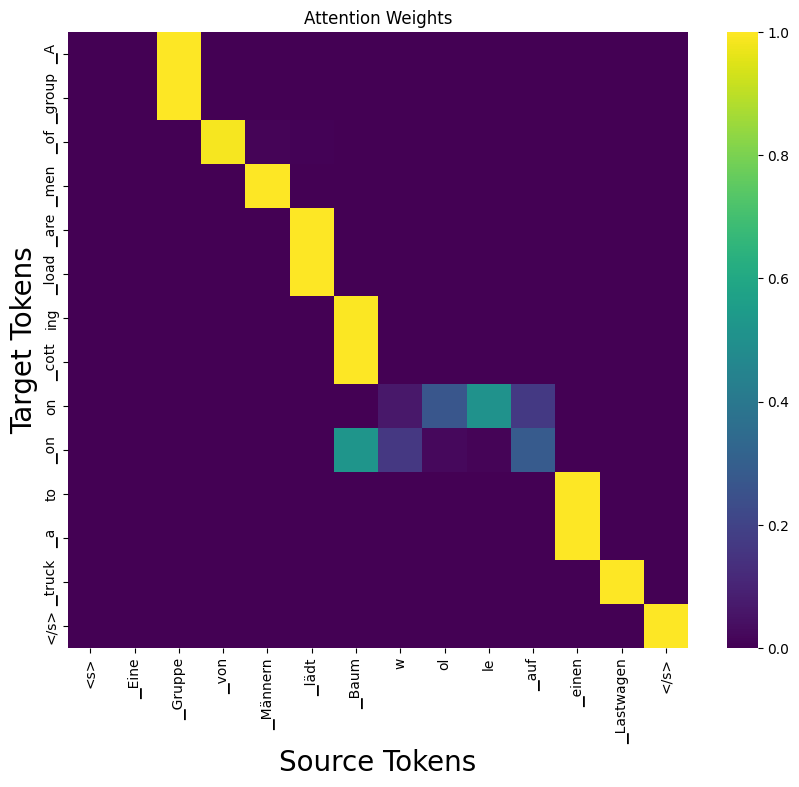

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Take a source/target pair and visualize the attention weights using a heatmap
source = ["Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen"]
source = make_batch(source)
target = ["A group of men are loading cotton onto a truck"]
target = make_batch(target)

# Get the attention weights for this source/target pair
attention_model.eval()
with torch.no_grad():
    encoder_output, encoder_mask, encoder_hidden = attention_model.encode(
        source)
    decoder_input = target[:-1]
    logits, _, attention_weights = attention_model.decode(decoder_input,
                                  encoder_hidden, encoder_output, encoder_mask)

# Shape to matrix
attention_matrix = attention_weights[:, 0, :].cpu().numpy()

# Get actual token from sentencepiece so we can visualize
source_pieces = vocab.IdToPiece(source[:, 0].tolist())
target_pieces = vocab.IdToPiece(target[1:, 0].tolist())

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix, xticklabels=source_pieces,
            yticklabels=target_pieces, cmap='viridis')
plt.xlabel("Source Tokens",fontsize=20)
plt.ylabel("Target Tokens",fontsize=20)
plt.title("Attention Weights")
plt.show()


Very cool! The model gets a lot of the 1-1 word translations correct like "truck = Lastwagen" and "men = Männern." It also roughly captures the situation in which there is not a 1-1 mapping like "lädt = is loading," in which case the model predicts "lädt = are load."

#Acknowledgements
This project was adapted from UC Berkeley's CS288: Natural Language Processing course: https://cal-cs288.github.io/sp22/
